In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
from datalife import get_critical_path, caterpillar_tree, remove_cpath_from_graph

In [3]:
# find_caterpillar_forest in code
def find_caterpillar_forest(G):
    
    annotation = {}
    CT_s = []
    dependent_i_edges = []
    dependent_o_edges = []
    cf = nx.DiGraph()
    x = y = 0
    DEBUG = False
    ct_level = 0
    while(G.nodes or G.edges):
        print("###") if DEBUG is True else None
        # find a critical path
        cpath = get_critical_path(G)
        # extract the CT along the critical path
        CT_c = caterpillar_tree(G, cpath)
        # Remove the vertices and edges only along the critical path
        removed_g = remove_cpath_from_graph(G, cpath)
        ct_segment_first_found = None
        queue_to_update = []
        # (find dependencies across CT_s) for each of the vertices,
        # v_c on the critical path of the current caterpillar tree, CT_c
        is_dependent_o_edges = is_dependent_i_edges = 0

        for ct_i in CT_s:
            is_dependent_o_edges = is_dependent_i_edges = 0
            node_cache = []
            print('===') if DEBUG is True else None
            nodes_in_CT_c = list(CT_c.nodes)
            node = nodes_in_CT_c.pop(0)
            while node:
                print("start ", node) if DEBUG is True else None
                # if there is an edge between v_p and v_c, 
                # add a dependency edge between CT_c  and ct_i
                o_edges = ct_i.out_edges(node)
                i_edges = ct_i.in_edges(node)
                dependent_i_edges += list(i_edges)
                dependent_o_edges += list(o_edges)
                u_of_edge = v_of_edge = None
                #ode_cache.append(node)
                if(len(o_edges) > 0):
                    u_of_edge = CT_c
                    v_of_edge = ct_i
                    # prevent cycle
                    #if is_dependent_ct_found > 0 and len(dependent_i_edges) > 0:
                    #    u_of_edge = CT_c.copy()
                    #    x += 1
                    is_dependent_o_edges += 1
                if(len(i_edges) > 0):
                    u_of_edge = ct_i
                    v_of_edge = CT_c
                    #if is_dependent_ct_found > 0 and len(dependent_o_edges) > 0:
                    #    v_of_edge = CT_c.copy()
                    #    x += 1                        
                    is_dependent_i_edges += 1
                print("is 1:", is_dependent_i_edges, is_dependent_o_edges) if DEBUG is True else None
                if is_dependent_i_edges > 0 and is_dependent_o_edges > 0:
                    #node_cache.append(node)
                    ct_segment_remaining = remove_cpath_from_graph(CT_c, node_cache)
                    CT_s.append(nx.subgraph(CT_c, node_cache))
                    is_dependent_o_edges = is_dependent_i_edges = 0
                    node_cache = []
                    CT_c = ct_segment_remaining
                    nodes_in_CT_c = list(ct_segment_remaining.nodes)
                    node = nodes_in_CT_c.pop(0)
                    print(ct_segment_remaining.nodes) if DEBUG is True else None
                    print("****") if DEBUG is True else None
                    continue
                    #break
                else:#if is_dependent_i_edges == 0 and is_dependent_o_edges == 0:
                    node_cache.append(node)
                    print("node, cache:", node,node_cache) if DEBUG is True else None
                print("is:", is_dependent_i_edges, is_dependent_o_edges) if DEBUG is True else None
                    
                if u_of_edge and v_of_edge:
                    edge_type = 'in' if len(i_edges) > 0 else 'out'
                    queue_to_update.append([edge_type, u_of_edge, v_of_edge, x, y])  
                print("nodes", nodes_in_CT_c) if DEBUG is True else None
                node = nodes_in_CT_c.pop(0) if len(nodes_in_CT_c) > 0 else []
                # end while loop for node search #

            # prevent cyclic
            print(queue_to_update) if DEBUG is True else ''
            cnt = 0
            for edge_type, u, v, x, y in queue_to_update:
                cf.add_edge(u, v)
                if 'ct_level' in u:
                    ct_level = u['ct_level']
                cf.add_node(u, pos=(x, y), ct_level=ct_level, ct_depth=cnt)
                x += 1
                y += 1
                ct_level_ = ct_level
                if 'ct_level' in v:
                    ct_level_ = u['ct_level']
                else:
                    ct_level_ = ct_level + 1
                cf.add_node(v, pos=(x, y), ct_level=ct_level_, ct_depth=cnt)
                x += 1
                y += 1
                cnt += 1
        
        ct_level += 1
        annotation[CT_c] = {'dependent_ct_count': is_dependent_o_edges + is_dependent_i_edges}
        dependent_edges = list(set(dependent_i_edges + dependent_o_edges))
        CT_s.append(CT_c)
        G = removed_g
    return (cf, dependent_edges, annotation)

In [4]:
def get_unique_position(pos_dict):
    check = {}
    for k, p in pos_dict.items():
        if p not in check:
            check[p] = {'last_x': [p[0]]}
        else:
            last_x = check[p]['last_x'][-1]
            pos_dict[k] = (last_x + 1, p[1])
            check[p]['last_x'].append(last_x + 1)
            
def get_pos_(G):
    pos = {}
    space = 1
    x = 1
    y = 1
    last_y = 1
    for u, v in G.edges:
        if u in pos:
            x, y = pos[u]
        else:
            y_add = 0
            if v in pos:
                next_x, next_y = pos[v]
                u_attr, v_attr = G.nodes[u], G.nodes[v]
                #print(G.nodes[u], G.nodes[v])
                y_add = (u_attr['ct_level'] - v_attr['ct_level']) * space
                pos[u] = next_x + space , next_y + y_add
            else:
                new_y = last_y - space
                pos[u] = x, new_y
                y = new_y
        if v in pos:
            x, y = pos[v]
        else:
            pos[v] = (pos[u][0], pos[u][1] - space)
            last_y = min(last_y, pos[u][1] - space)
        last_y = min(last_y, y)
    get_unique_position(pos)
    return pos


In [5]:
g_1kgenome = nx.read_gpickle('1k_genomes.gpickle')

In [6]:
cf_1k, dependent_edges_1k, anno_1k = find_caterpillar_forest(g_1kgenome)
cf_1k#, dependent_edges_1k, anno_1k

In [7]:
pos_1k = get_pos_(cf_1k)

In [8]:
cf_1k_labels = {}
idx = 1
for node in cf_1k.nodes:
    cf_1k_labels[node] = f'ctree_{idx}'
    idx += 1

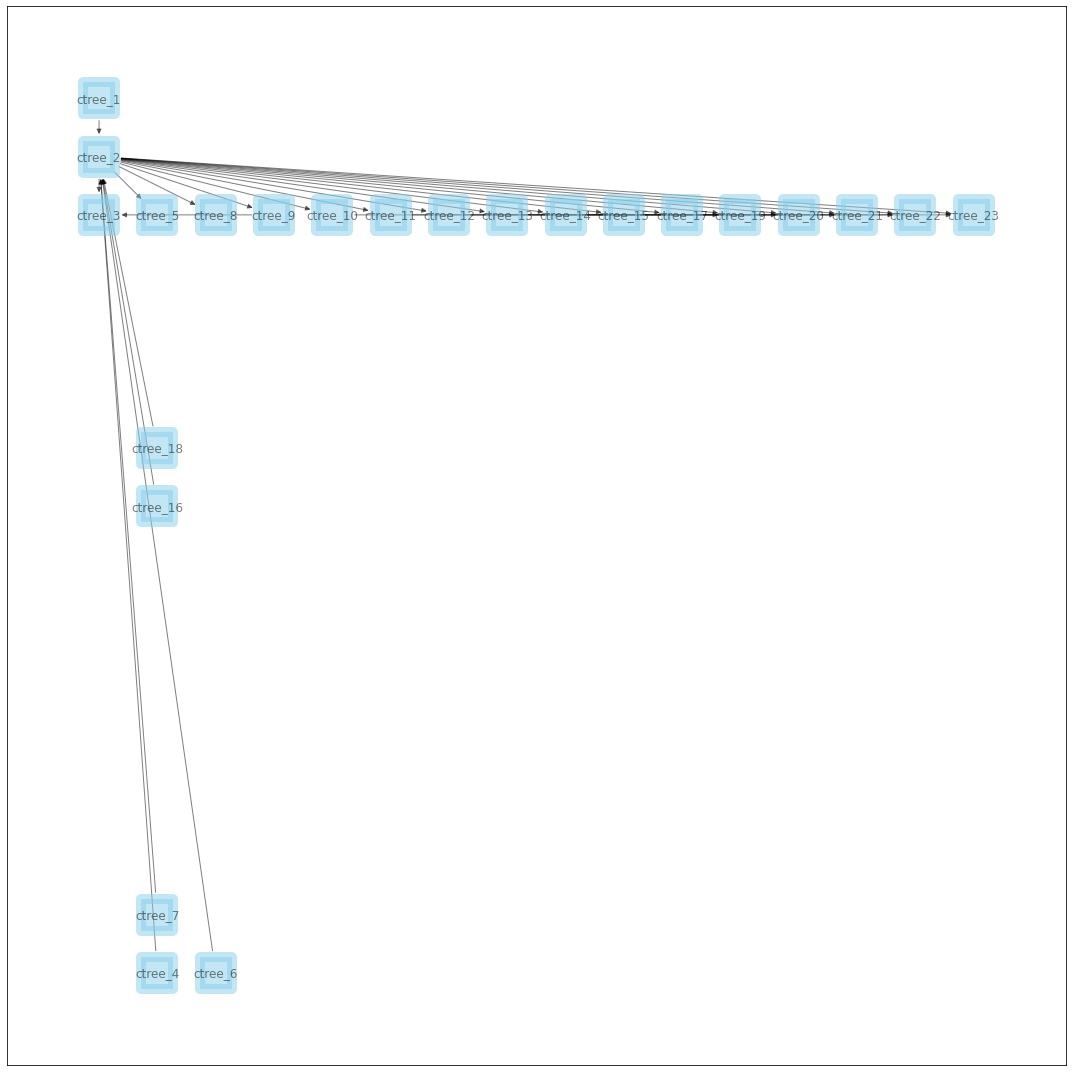

In [9]:
fig, ax = plt.subplots( figsize=(15, 15))
nx.draw_networkx(cf_1k, pos = pos_1k, labels=cf_1k_labels, with_labels=True, ax=ax, node_size=1000, node_color="skyblue",
                 node_shape="s", alpha=0.5, linewidths=10)
fig.tight_layout()
plt.show()

In [10]:
try:
    nx.find_cycle(cf_1k, orientation="original")
except nx.exception.NetworkXNoCycle as e:
    print(e)


No cycle found.
